Imports:

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint
from tqdm import tqdm

d:\Code\MRes\2022-PracticalSessions\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Introduction:

The Lorentz equations are a set of ordinary differential equations that produce chaotic solutions given certain parameter values (ρ > 24.74). They are highly sensitive to their initial conditions. 

In [2]:
#  From https://scipython.com/blog/the-lorenz-attractor/
sigma, beta, rho = 10, 2.667, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

In [3]:
def plot_lorentz(soln, t):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_phase = fig.add_subplot(projection='3d')
    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')

    s=10
    n=len(t)
    line_segments = [(soln.cpu().numpy()[:,:,0][i:i+s+1], soln.cpu().numpy()[:,:,1][i:i+s+1], soln.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
    segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
    #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
    #ax_phase.add_collection(lines)
    for i, line in enumerate(line_segments):
        ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

    #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.set_zlabel('z')
    ax_phase.legend()
    plt.show()

The Lorentz system can be solved numerically (here I use the dopri5 method which itself is a Runge-Kutta solver) over some time step in order to obtain a trajectory.

Below the system is solved for two example sets of parameters, yielding quite different solutions. In the first case, a value of 15 is used for ρ. This case does not exhibit chaotic solutions. In the second case, a value of ρ=28 is used which produces a chaotic solution with a distinct shape which has inspired the name for the "butterfly effect" in popular references to chaos theory.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


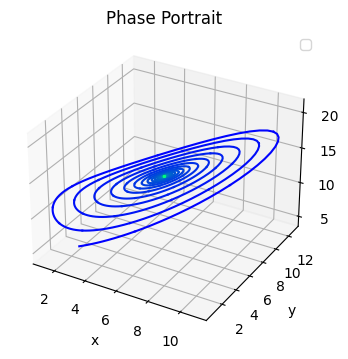

In [26]:
sigma, beta, rho = 10, 8/3, 15
true_y0 = torch.tensor([[2., 3., 4.]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 2000).to(device) # time over which ODE is integrated
with torch.no_grad():
    soln = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

plot_lorentz(soln, t)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


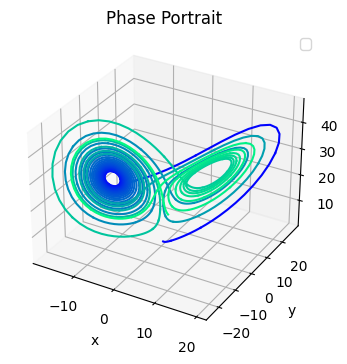

In [23]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 2000).to(device) # time over which ODE is integrated
with torch.no_grad():
    soln = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

plot_lorentz(soln, t)

Since neural networks themselves are differentiable mathematical functions, this project aims to train a neural network to replicate the Lorentz system of equations, such that when it is integrated over time it replicates the true trajectory of the system as closely as possible.

In order to achieve this, the loss function used in the training step is defined as the average difference between the predicted and true trajectories of the system at all points in time.

Initially, a simple neural network was made and trained to try and predict the equations. The first 90% of time points were used as training data and the final 10% as validation data.

Generate solution to equations:

In [31]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 2000).to(device) # time over which ODE is integrated
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

Define neural net:

In [4]:
class ODENN(nn.Module):

    def __init__(self, layers):
        super(ODENN, self).__init__()

        self.layers = layers

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    
    def trainmodel(self, true_y, t, optimizer, epochs, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_y = true_y[:int(len(true_y)*train_ratio)]
        train_t = t[:int(len(t)*train_ratio)]
        validation_y = true_y[int(len(true_y)*train_ratio):]
        validation_t = t[int(len(t)*train_ratio):]
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            pred_y = odeint(self, train_y[0], train_t).to(device)
            loss = torch.mean(torch.abs(pred_y - train_y))
            loss.backward()
            optimizer.step()
            iterations.append(epoch)
            train_losses.append(float(loss))
            if validation:
                pred_y = self.predict(validation_y[0], validation_t)
                loss = torch.mean(torch.abs(pred_y - validation_y))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    
    def predict(self, y0, t):
        with torch.no_grad():
            pred_y = odeint(self, y0, t).to(device)
        return pred_y
        

        

In [5]:
def plot_trajectory(pred_y, true_y, t):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, projection='3d')

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y,z')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,0], 'k-', label='true x')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,1], 'm-', label='true y')
    ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,2], 'b-', label='true z')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,0], 'k--', label='predicted x')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,1], 'm--', label='predicted y')
    ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,2], 'b--', label='predicted z')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    ax_traj.legend()

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.plot(true_y.cpu().numpy()[:,:,0], true_y.cpu().numpy()[:,:,1], true_y.cpu().numpy()[:,:,2], 'g--', label="True")

    s=10
    n=len(t)
    line_segments = [(pred_y.cpu().numpy()[:,:,0][i:i+s+1], pred_y.cpu().numpy()[:,:,1][i:i+s+1], pred_y.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
    segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
    for i, line in enumerate(line_segments):
        ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.set_zlabel('z')
    ax_phase.legend()
    plt.show()

100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


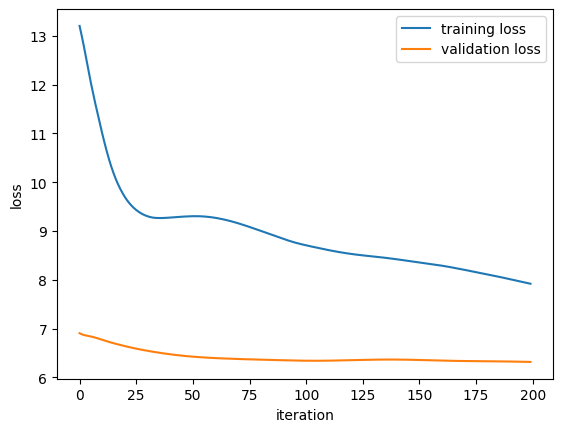

Final training loss: 7.919563293457031


In [43]:
net=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
net.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

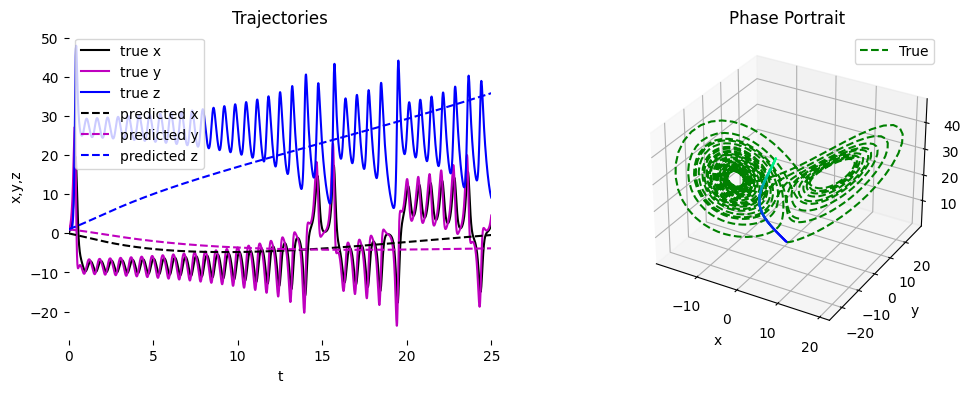

In [44]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

Here it can be seen that the training loss decreases quickly and then starts to plateau. At the end of training the loss remains high ~8 and this can be seen in the trajectory and phase plots as the predicted trajectories differ significantly from the true trajectories. This is expected given the definiton of the loss as the average difference between the trajectories.

In order to improve this, a more complex model was trained which included more layers in order to learn more information about the system at hand.

100%|██████████| 200/200 [02:30<00:00,  1.33it/s]


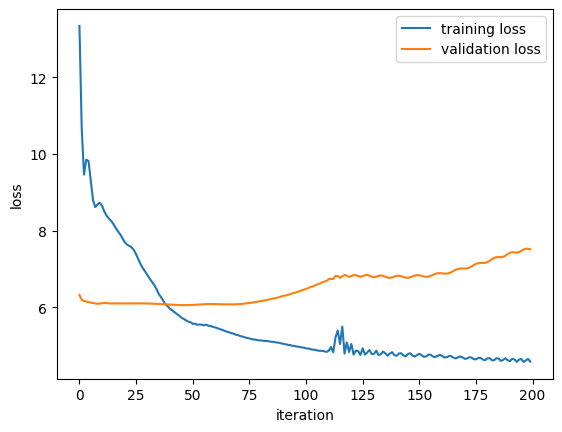

Final training loss: 4.577488422393799


In [45]:
net=ODENN(nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
net.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

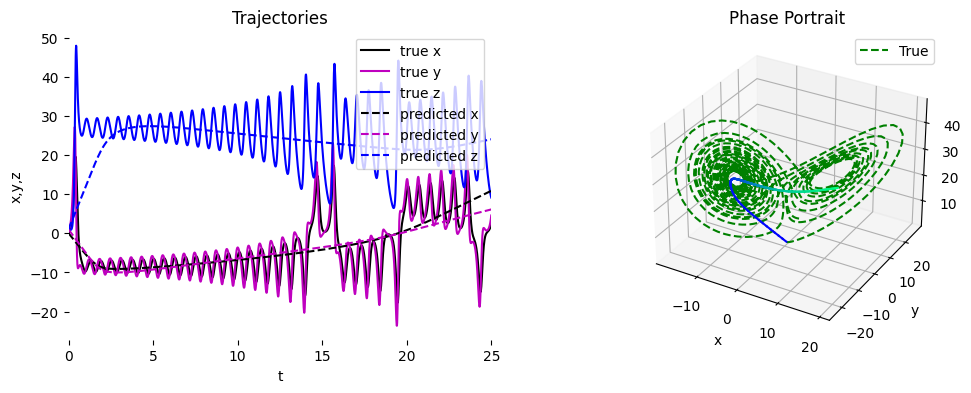

In [46]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

It can be seen now from the left plot that despite some significant deviations at the start, the predicted trajectory follows the overall trend of the true trajectories, but fails to capture the detail in the higher frequency oscillations. It looks almost like a rolling average was taken over the true trajectories, indicating that not enough information was learned. This makes sense given that the loss is defined as the average of the difference between the true and predicted trajectories. Thus, by further decreasing the loss the model should be able to predict these higher frequency oscillations. To do this a more complex model will be trained.

It should be noted that the validation loss is seen to increase during training indicating that the model has started to overfit to the training dataset. 

This paper: https://arxiv.org/pdf/1910.07291.pdf talks about using "ensemble solutions, i.e. creating datasets comprising of various simulations starting from different initial conditions. In order to increase the robustness of the model to variations in initial values I Introduced batching and trained over multiple batches each with random initial conditions. This aims to help the model better learn the underlying system of equations and not just overfit to the data values at one set of initial parameters.

The code was restructured to allow datasets to be more easily swapped around and batching was implemented:

Helper code:

In [6]:
from dataclasses import dataclass

@dataclass
class Dataset:
    y: torch.tensor
    t: torch.tensor

    @staticmethod
    def get_batch(true_y, t, batch_size, batch_time):
        s = torch.from_numpy(np.random.choice(np.arange(len(t) - batch_time, dtype=np.int64), batch_size, replace=False))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


Batching was introduced to randomly select y_true values as starting y0 vectors and then to select the next batch_time timesteps and return batch_y i.e. the true values of the equations starting with vector batch_y0[n] and integrating between 0-t[i] where i = batch_time.

Define Neural ODE:

In [8]:
class ODENN(nn.Module):

    def __init__(self, layers):
        super(ODENN, self).__init__()

        self.layers = layers

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    
    def trainmodel(self, dataset, optimizer, epochs, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            iterations.append(epoch)
            true_y = dataset.y
            t = dataset.t
            train_y = true_y[:int(len(true_y)*train_ratio)]
            train_t = t[:int(len(t)*train_ratio)]
            validation_y = true_y[int(len(true_y)*train_ratio):]
            validation_t = t[int(len(t)*train_ratio):]

            batch_y0, batch_t, batch_ytrue = Dataset.get_batch(train_y, train_t, batch_size=100, batch_time=100)
            pred_y = odeint(self, batch_y0, batch_t).to(device)


            loss = torch.mean(torch.abs(pred_y - batch_ytrue))
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))
            if validation:
                batch_y0, batch_t, batch_ytrue = Dataset.get_batch(validation_y, validation_t, batch_size=50, batch_time=50)
                pred_y = self.predict(batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_ytrue))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    
    def predict(self, y0, t):
        with torch.no_grad():
            pred_y = odeint(self, y0, t).to(device)
        return pred_y
        

        

In [9]:
class ODENN(nn.Module):

    def __init__(self, layers):
        super(ODENN, self).__init__()

        self.layers = layers

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    
    def trainmodel(self, dataset, optimizer, epochs, batch_size=100, batch_time=100, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            iterations.append(epoch)
            true_y = dataset.y
            t = dataset.t
            train_y = true_y[:int(len(true_y)*train_ratio)]
            train_t = t[:int(len(t)*train_ratio)]
            validation_y = true_y[int(len(true_y)*train_ratio):]
            validation_t = t[int(len(t)*train_ratio):]

            batch_y0, batch_t, batch_ytrue = Dataset.get_batch(train_y, train_t, batch_size, batch_time)
            pred_y = odeint(self, batch_y0, batch_t).to(device)


            loss = torch.mean(torch.abs(pred_y - batch_ytrue))
            loss.backward()
            optimizer.step()
            train_losses.append(float(loss))
            if validation:
                batch_y0, batch_t, batch_ytrue = Dataset.get_batch(validation_y, validation_t, batch_size=50, batch_time=50)
                pred_y = self.predict(batch_y0, batch_t)
                loss = torch.mean(torch.abs(pred_y - batch_ytrue))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    
    def predict(self, y0, t):
        with torch.no_grad():
            pred_y = odeint(self, y0, t).to(device)
        return pred_y
        

        

100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


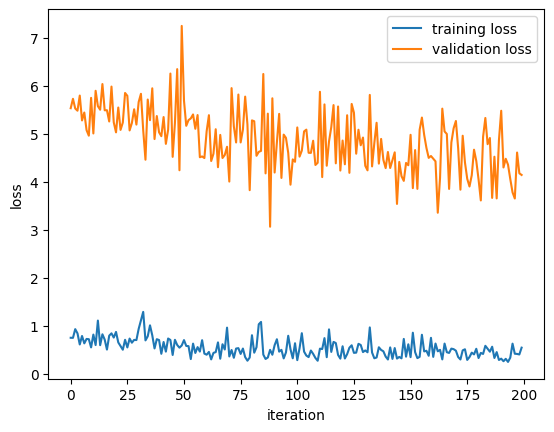

Final training loss: 0.547870397567749


In [58]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

dataset = Dataset(y=true_y, t=t)

net=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
net.trainmodel(dataset, optimizer, epochs=200, batch_size=10, batch_time=10, train_ratio=0.9)

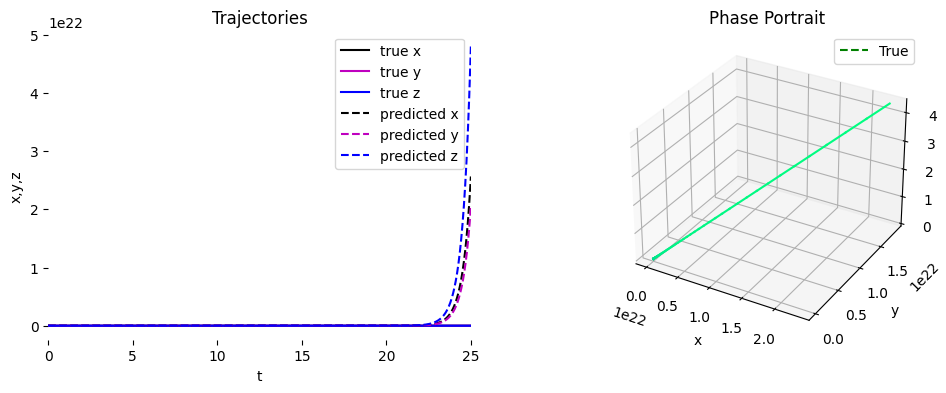

In [59]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

Here the model can be seen performing very poorly. A small batch_size was used, i.e. the number of different initial conditions to be trained on, and they were only trained with a small batch_time i.e. for 10 timesteps each. This made for a very fast training time, but very poor performance as shown by the high validation loss, showing that the model had not learned enough information about the system to make accurate predictions. To combat this, both the batch_size and the batch_time were increased to allow the model to train on a larger number of initial conditions and also to train each case for longer.

100%|██████████| 200/200 [01:41<00:00,  1.98it/s]


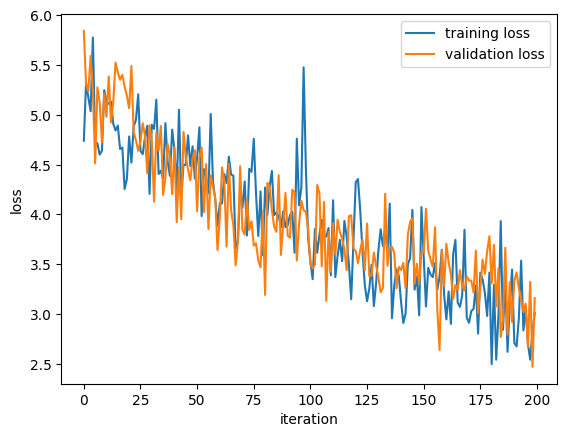

Final training loss: 3.0095787048339844


In [64]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

dataset = Dataset(y=true_y, t=t)

net=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
net.trainmodel(dataset, optimizer, epochs=200, batch_size=100, batch_time=100, train_ratio=0.9)

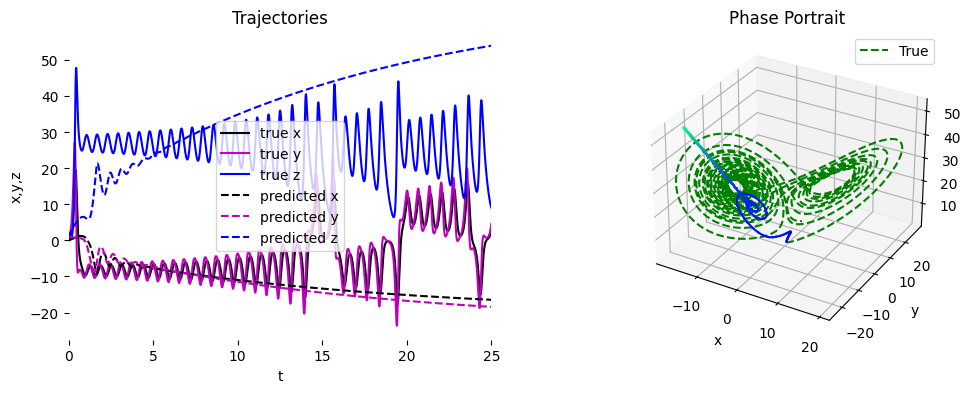

In [65]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

This model appears to be learning the system better, while the predicted trajectory is still mostly incorrect, it can be seen that the trajectory has started to follow a similar circular path at points. The final training loss is around 3 after 200 iterations, however the loss is still decreasing significantly thus I decided to train for longer. It should also be noted that I changed to using ReLU activation functions due to their superior gradient flow properties when compared to the Tanh function.

100%|██████████| 1500/1500 [32:28<00:00,  1.30s/it]


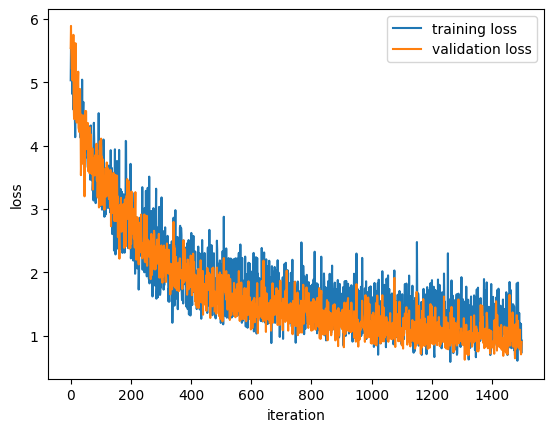

Final training loss: 0.9223892092704773


In [21]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

dataset = Dataset(y=true_y, t=t)

net=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
net.trainmodel(dataset, optimizer, epochs=1500, batch_size=100, batch_time=100, train_ratio=0.9)

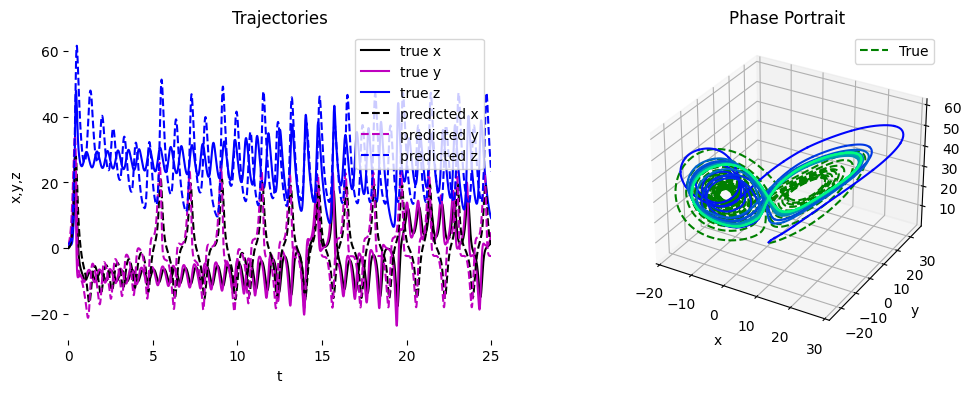

In [40]:
pred_y = net.predict(true_y[0], t)
plot_trajectory(pred_y, true_y, t)

This model was trained for significantly longer and the predicted trajectories are much closer to the true trajectories. The loss curves look good: they are observed to decrease quickly and gradually plateau, and do not seem to be overfitting. Additionally, since the validation set is the final 10% of time points, it can be seen that the the model was performing fairly well beyond the training time range. 

Model evaluation:

I tried extending this time range further without carrying out any further training on the model.

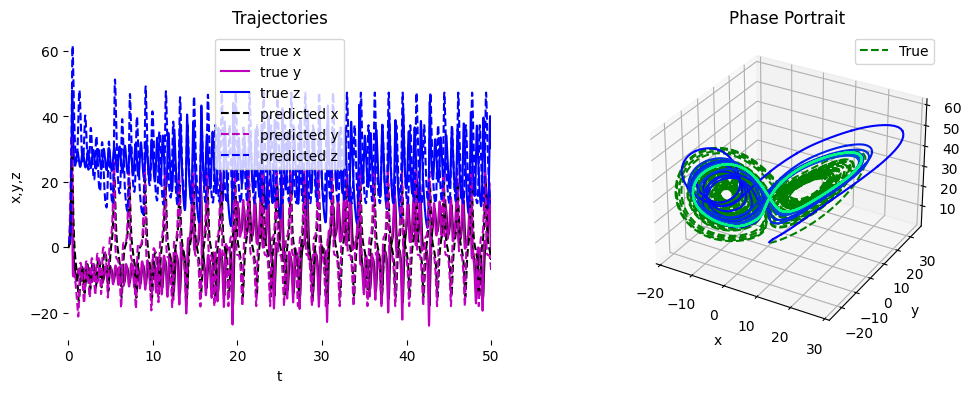

In [43]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t_extended = torch.linspace(0., 50., 7000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y_extended = odeint(Lambda(), true_y0, t_extended, method='dopri5') # calculate true_y values

pred_y_extended = net.predict(true_y_extended[0], t_extended)
plot_trajectory(pred_y_extended, true_y_extended, t_extended)

Even at double the time range, the model appears to perform well given the same set of input parameters. The solution does of course differ from the true values however the correct overall trajectories are followed throughout.

Next I tried varying the initial conditions.

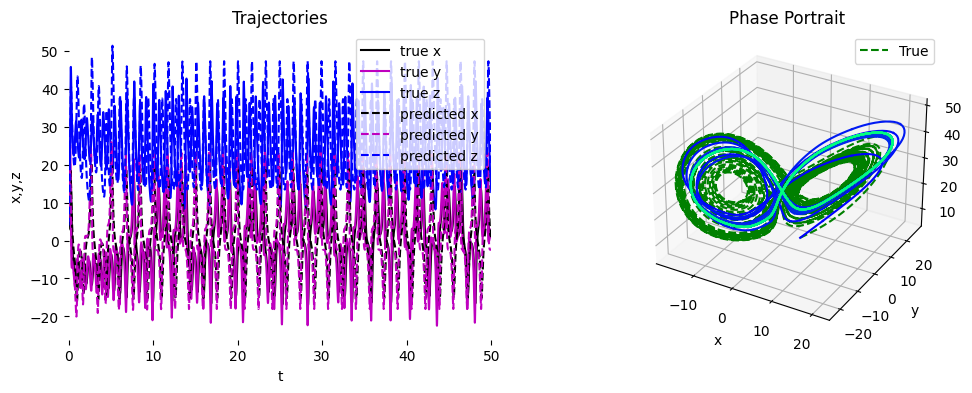

In [33]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[3., 5., 4.]]).to(device)     # starting vector for ODE
t_extended = torch.linspace(0., 50., 7000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y_extended = odeint(Lambda(), true_y0, t_extended, method='dopri5') # calculate true_y values

pred_y_extended = net.predict(true_y_extended[0], t_extended)
plot_trajectory(pred_y_extended, true_y_extended, t_extended)

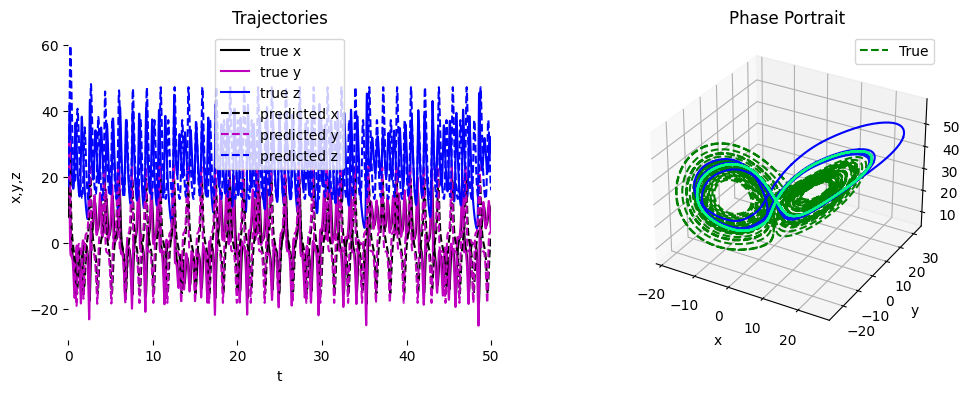

In [38]:
sigma, beta, rho = 10, 8/3, 28
true_y0 = torch.tensor([[8., 19., 17.]]).to(device)     # starting vector for ODE
t_extended = torch.linspace(0., 50., 7000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y_extended = odeint(Lambda(), true_y0, t_extended, method='dopri5') # calculate true_y values

pred_y_extended = net.predict(true_y_extended[0], t_extended)
plot_trajectory(pred_y_extended, true_y_extended, t_extended)

The predicted trajectories that followed the correct shape of the true trajectories even when given large initial values.

Next I tried to make predictions on a dataset with different system parameters.

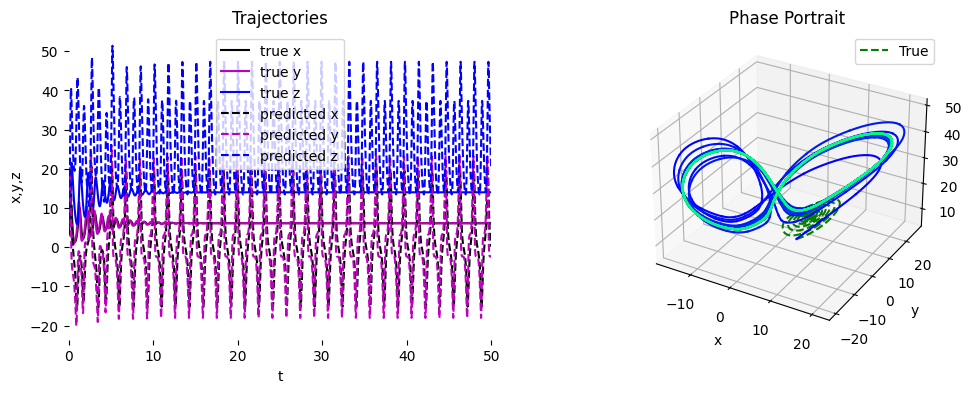

In [39]:
sigma, beta, rho = 10, 8/3, 15
true_y0 = torch.tensor([[3., 5., 4.]]).to(device)     # starting vector for ODE
t_extended = torch.linspace(0., 50., 7000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y_extended = odeint(Lambda(), true_y0, t_extended, method='dopri5') # calculate true_y values

pred_y_extended = net.predict(true_y_extended[0], t_extended)
plot_trajectory(pred_y_extended, true_y_extended, t_extended)

It can be seen that the model kept predicting the same shape as it did for the previous set of parameters which is incorrect in this case. This is to be expected however, as the model has no knowledge of the system parameters and thus it has only learned one set of solutions to the Lorentz system with fixed parameters instead of learning how the system itself behaves.

I then decided to train the model using the second set of input parameters to see how it performed in that case.

100%|██████████| 1500/1500 [13:13<00:00,  1.89it/s]


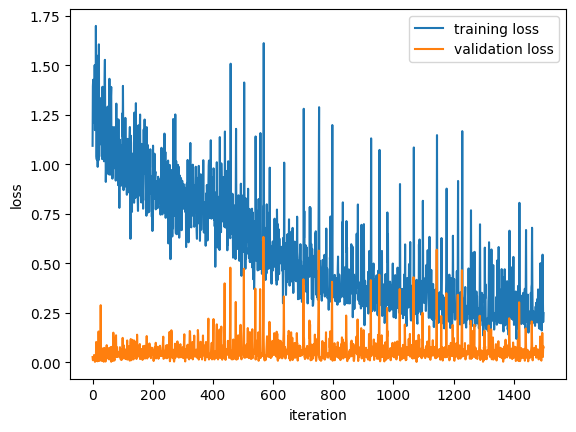

Final training loss: 0.2491166740655899


In [55]:
sigma, beta, rho = 10, 8/3, 15
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE
t = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y_diffparams = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values

dataset2 = Dataset(y=true_y_diffparams, t=t)

net2=ODENN(nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )).to(device)
        
optimizer = optim.RMSprop(net2.parameters(), lr=1e-3)
net2.trainmodel(dataset2, optimizer, epochs=1500, batch_size=100, batch_time=100, train_ratio=0.9)

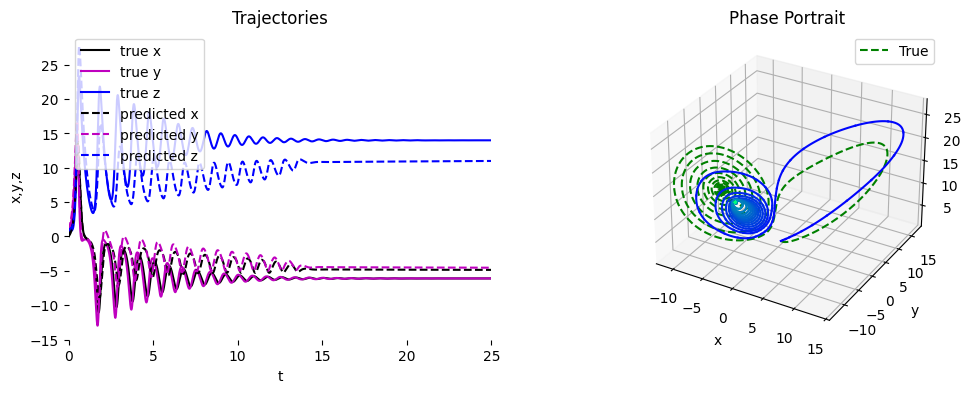

In [56]:
pred_y_diffparams = net2.predict(true_y_diffparams[0], t)
plot_trajectory(pred_y_diffparams, true_y_diffparams, t)

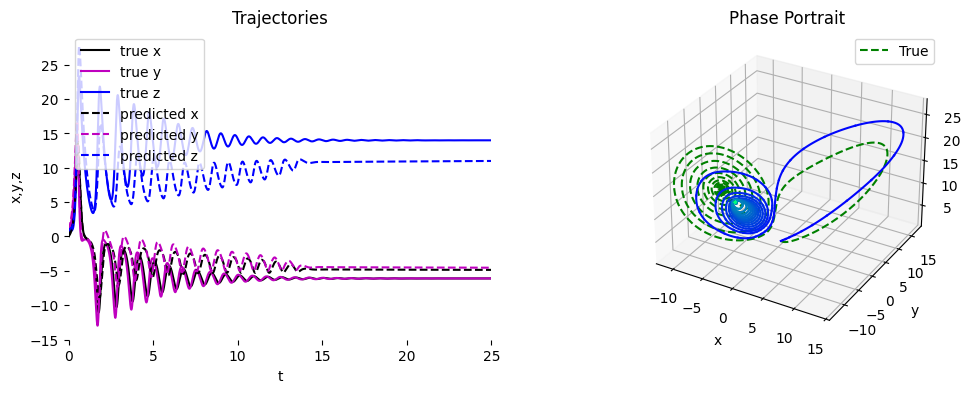

In [57]:
t_extended = torch.linspace(0., 25., 5000).to(device) # time over which ODE is integrated
with torch.no_grad():
    true_y_diffparams_extended = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values
pred_y_diffparams_extended = net2.predict(true_y_diffparams_extended[0], t_extended)
plot_trajectory(pred_y_diffparams_extended, true_y_diffparams_extended, t_extended)

The model appears to learn the overall behaviour of the system well again, however the trajectories differ and the final point the trajectory converges to appears to be different by a factor of around 30%.

Conclusion: